## Projeto final PLN - Sumarizador de documentos e tradução de sumarização

### Arthur Rizzo e Vitor Liu

## Resumo

Esse projeto tem como objetivo realizar melhorias e
implementar novos recursos ao [projeto realizado anteriormente](https://docs.google.com/document/d/13gVb1lcceNGXlPpneqkVGrRjgrEUrhPk). Portanto, explicaremos o novo processo de sumarização extrativa por clustering baseado no embedding de sentenças pelo modelo BERT e a implementação da tradução da sumarização. Além disso, explicaremos o funcionamento do modelo de tradução XLM utilizado e o porquê de escolhermos esse modelo.

## 1. Introdução

Este projeto aborda duas áreas de alta relevância universo de Processamento de Linguagem Natural(PLN). São elas a sumarização e a tradução. Os próximos parágrafos irão resumir como essas áreas se conectam com o PLN e porque são tão estudadas. Também serão tratadas algumas das técnicas utilizadas ao longo do estudo. 

A sumarização automática de documentos é uma técnica muito importante na área de Processamento de Linguagem Natural pois permite gerar uma representação resumida do conteúdo dos documentos. Assim, após a geração de sumários, não é totalmente necessário tratar documentos inteiros, mas apenas um resumo destes.

Tratando-se de textos, existem dois tipos de sumarização: a sumarização extrativa e a sumarização abtrativa. A extrativa seleciona frases ou pequenas partes do documento para ser o sumário; já a abstrativa gera frases baseadas no conteúdo do texto.

Existem diversos métodos para a realização da sumarização. Porém, o método escolhido é baseado no embedding de sentenças e realizando o clustering entre as sentenças.

O embedding é a transformação de algo em vetores. Isso possibilita desde a realização cálculos entre vetores até a utilização de modelos neurais. Na área de PLN, é commum gerar embeddings de palavras, mas não se limita a este.

O clustering é a prática de agrupar objetos baseado em determinadas caracteristicas. Para isso, há vários algoritmos que realizam a clusterização, como o algoritmo baseado em hierarquia e o algoritmo k-means.

A tradução também é uma técnica muito importante na área de PLN pois pode deixar textos mais acessíveis para línguas não tão populares e, do contrário, aproximar e popularizar textos e culturas de línguas menos conhecidas.

Como pode-se notar, por sí só ambas as áreas, sumarização e tradução, são ferramentas poderosas. Curiosamente, somadas, podem propiciar soluções para problemas ainda mais complexos de diversas naturezas e aplicações. Dentre elas, uma forma de categorizar documentos estrangeiros por tópico e seleção de informação em língua estrangeira. Graças aos avanços acadêmicos e práticos nas diversas áreas do PLN, os modelos que estão sendo desenvolvidos estão se tornando cada vez mais certeiros e, isso é bastante motivante. 

Portanto, este trabalho foi realizado com bastante interesse, buscando significado nas esferas acadêmicas e práticas. Ao longo deste notebook serão abordados os processos envolvidos no projeto, bem como, os resultados e considerações dos autores. 

## 2. Metodologia

O projeto segue os passos a seguir:

1. Pré-processamento
2. Tokenização e embedding
3. Clusterização
4. Sumarização
5. Tradução

Todo projeto foi feito em python, mais especificamente baseado na biblioteca de PLN `transformers` (baseado em `torch`) e na biblioteca de análise de dados `scikit-learn`.

O dataset utilizado foi o [cnn-stories-tokenized](https://github.com/JafferWilson/Process-Data-of-CNN-DailyMail).


In [ ]:
%%capture
# Download da biblioteca transformers e seaborn
import sys
!{sys.executable} -m pip install transformers
!pip3 install seaborn

In [ ]:
# Imports
from transformers import BertTokenizer, BertModel, XLMTokenizer, XLMWithLMHeadModel, T5Tokenizer, T5ForConditionalGeneration
import torch
import os
import re
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from random import random
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download do dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0BzQ6rtO2VN95cmNuc2xwUS1wdEE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0BzQ6rtO2VN95cmNuc2xwUS1wdEE" -O cnn-stories-tokenized.zip && rm -rf /tmp/cookies.txt
!unzip -q cnn-stories-tokenized.zip 

--2020-06-24 17:19:15--  https://docs.google.com/uc?export=download&confirm=406v&id=0BzQ6rtO2VN95cmNuc2xwUS1wdEE
Resolving docs.google.com (docs.google.com)... 172.217.204.139, 172.217.204.101, 172.217.204.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-58-docs.googleusercontent.com/docs/securesc/kabe2c7ou0vncf8gvthog4hp1eummv73/ko4dknd4vhnh1fd9c9uef1spsrh8dei3/1593019125000/14902801042381301132/12277873770934232414Z/0BzQ6rtO2VN95cmNuc2xwUS1wdEE?e=download [following]
--2020-06-24 17:19:15--  https://doc-0k-58-docs.googleusercontent.com/docs/securesc/kabe2c7ou0vncf8gvthog4hp1eummv73/ko4dknd4vhnh1fd9c9uef1spsrh8dei3/1593019125000/14902801042381301132/12277873770934232414Z/0BzQ6rtO2VN95cmNuc2xwUS1wdEE?e=download
Resolving doc-0k-58-docs.googleusercontent.com (doc-0k-58-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to doc-0k

### 2.1 Pré-processamento

Apesar de já estar tokenizado, foi necessário realizar um pré-processamento mais específico sobre o dataset. Portanto, esse pré-processamento é exclusivo para esse dataset. Foram retirados números e stopwords, e para o restante, todas as palavras foram colocadas em minúsculo.

Por causa do tamanho do dataset e do tempo de execução de todos os passos, trabalhadou-se com apenas uma pequena amostra do dataset (1% aprox.), escolhido randomicamente.

In [ ]:
def preprocess(sent):
    def convert(word):
        # Verifica se é um número.
        try:
            _ = int(word)
            return '<num>'
        except:
            pass

        if "\n" in word:
            return "<wierd>"

        lower = word.lower()
        if lower == "@highlight":
            return "<wierd>"
        if lower == "-lrb-" or lower == "cnn" or lower == "-rrb-":
            return "<wierd>"
        if lower != "u.s.":
            lowern = re.sub('[^A-Za-z0-9]+', '', lower)
            #lowern = re.sub("!\,\.;:<>\/\?~\^@#\$%&=-\+_´`\(\)\[]{}\\'", "", lower)
            lower = lowern
        if not len(lower):
            return "<wierd>"
        return '<stop>' if lower in STOPWORDS else lower
    
    processed = [convert(word) for word in sent.split(" ")]
    forbidden_words = set(('<num>', '<stop>', '<wierd>'))
    return [word for word in processed if word not in forbidden_words]

In [ ]:
try:
    with open("doc_sents.pickle", "rb") as fp:
        doc_sents = pickle.load(fp)
    print("Arquivo 'doc_sents.pickle' carregado")
except FileNotFoundError as e:
    doc_sents = defaultdict(list)
    doc_sents_highlight = defaultdict(list)
    STOPWORDS = set(stopwords.words('english'))
    for r, d, f in os.walk("/content/cnn_stories_tokenized/"):
        for file in f:
            if random() <= 0.992:
                continue
            with open(os.path.join(r, file), "r", encoding="utf-8") as fp:
                highlight = False
                line = fp.readline()
                while line:
                    if line == "@highlight\n":
                        highlight = True
                        line = fp.readline()
                    if line is "\n" or len(line) == 1:
                        line = fp.readline()
                        continue
                    prepro_line = preprocess(line)
                    if not highlight:
                        doc_sents[file].append(prepro_line)
                    else:
                        doc_sents_highlight[file].append(prepro_line)
                    line = fp.readline()
    with open("doc_sents.pickle", "wb") as fp:
        pickle.dump(doc_sents, fp)

print("Quantidade de documentos processados: {}".format(len(doc_sents)))

Quantidade de documentos processados: 749


### 2.2 Tokenização e embedding

A tokenização e o embedding foram executados através do modelo `bert-base-uncased`, da biblioteca `transformers`. A partir de tokens, esse modelo consegue consegue gerar os embeddings.

Como esse modelo realiza apenas embeddings de palavras, foi necessário utilizar a técnica de Continuous Bag of Words (CBOW) para transformar os conjuntos de vetores de diferentes palavras em apenas um conjunto de vetores, representando a sentença. Basicamente, o CBOW calcula a média entre as palavras de cada sentença para representar a própria sentença. É válido notar que, o CBOW não é a única técnica disponível para se converter embeddings de palavra em embeddings de sentença, no entanto, este é bastante prático de se implementar. 

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
try:
    with open("doc_cbow.pickle", "rb") as fp:
        doc_cbow = pickle.load(fp)
    print("Arquivo 'doc_cbow.pickle' carregado")
except FileNotFoundError as e:
    doc_sents_size = len(doc_sents)
    count = 0
    doc_cbow = {}
    for k in doc_sents.keys():
        print("\r{}/{} - {}".format(count, doc_sents_size, k), end="")
        count += 1
        cbow = []
        for sent in doc_sents[k]:
            if not sent:
                continue
            token_ids = tokenizer.encode(sent)
            tokens_tensor = torch.tensor([token_ids])
            segments_tensors = torch.tensor([0] * len(token_ids))
            with torch.no_grad():
                outputs = model(tokens_tensor, token_type_ids=segments_tensors)
                encoded_layers = outputs[0]
                embedding_words = encoded_layers.numpy().squeeze()
                embedding_sent = embedding_words.mean(axis=0)
            #doc_word_vecs[k].append(embedding_words)
            cbow.append(embedding_sent)
        
        doc_cbow[k] = cbow
    print("\r{}/{} - {}".format(count, doc_sents_size, k))
    with open("doc_cbow.pickle", "wb") as fp:
        pickle.dump(doc_cbow, fp)

749/749 - b3858ea6ae71f109a7eac9493a1057f0c4f31996.story


### 2.3 Clusterização

A clusterização foi implementada com o algoritmo k-means, da biblioteca `sklearn`. Esse algoritmo realiza o agrupamento dado uma quantidade k de grupos. Assim, os objetos a serem agrupados são separados baseado na distância da média de cada grupo.

Para cada documento, foram definidos 2 clusters.

In [ ]:
try:
    with open("doc_clusters.pickle", "rb") as fp:
        doc_clusters = pickle.load(fp)
    print("Arquivo 'doc_clusters.pickle' carregado")
except FileNotFoundError as e:
    doc_sents_size = len(doc_sents)
    count = 0
    doc_clusters = defaultdict(list)
    n_erros = 0
    for doc in list(doc_cbow.keys()):
        print("\r{}/{} - {}".format(count, doc_sents_size, k), end="")
        count += 1
        try:
            kmeans_cbow = MiniBatchKMeans(n_clusters=2, random_state=42)
            doc_clusters[doc] = (kmeans_cbow, kmeans_cbow.fit_transform(doc_cbow[doc]))
        except ValueError:
            n_erros += 1
            continue
    print("\r{}/{} - {}".format(count, doc_sents_size, k))
    print("N erros: {}".format(n_erros))
    with open("doc_clusters.pickle", "wb") as fp:
        pickle.dump(doc_clusters, fp)

749/749 - b3858ea6ae71f109a7eac9493a1057f0c4f31996.story
N erros: 1


### 2.4 Sumarização

A sumarização foi simples, dadas as etapas anteriores. Com cada cluster definido, bastou identificar a sentença mais próxima do centro de cluster para ser a frase sumarizadora, finalizando a sumarização extrativa. Como para cada documento foram definidos 2 clusters, a sumarização de cada documento é constituida por duas sentenças.

In [ ]:
def get_melhores(l_clusters):
    a = l_clusters[1]
    melhor = [None, None]
    for n_cluster in range(a.shape[1]):
        for i in range(len(a)):
            dist = a[i][n_cluster]

            if melhor[n_cluster] is None:
                melhor[n_cluster] = i
            else:
                dist_melhor = a[melhor[n_cluster]][n_cluster]
                if abs(dist) < abs(dist_melhor):
                    melhor[n_cluster] = i
    return melhor

In [ ]:
try:
    with open("doc_melhores_sents.pickle", "rb") as fp:
        doc_melhores_sents = pickle.load(fp)
    print("Arquivo 'doc_melhores_sents.pickle' carregado")
except FileNotFoundError as e:
    doc_sents_size = len(doc_sents)
    count = 0
    doc_melhores_sents = {}
    for doc in list(doc_clusters.keys()):
        print("\r{}/{} - {}".format(count, doc_sents_size, k), end="")
        count += 1
        doc_melhores_sents[doc] = get_melhores(doc_clusters[doc])
    print("\r{}/{} - {}".format(count, doc_sents_size, k), end="")
    with open("doc_melhores_sents.pickle", "wb") as fp:
        pickle.dump(doc_melhores_sents, fp)

748/749 - b3858ea6ae71f109a7eac9493a1057f0c4f31996.story

### 2.5 Tradução

A tradução foi feita com o modelo `XLM`. Mais especificamente, o modelo `xlm-mlm-ende-1024`. Esse é especifico para o inglês e o alemão.

Esse modelo é a implementação do Cross-lingual Language Model Pre Training. Suas funcionalidades são:
- Language model pretraining:
    - Casual Language Model (CLM)
    - Masked Language Model (MLM)
    - Translation Language Model (TLM)
- GLUE e XNLI fine-tuning
- Supervised / Unsupervised Machine Translation training

Para a questão de tradução, as técnicas de pré reinamento mais relevantes são o MLM e TLM.

A técnica MLM consiste em substituir tokens aleatórios da sentença por um token `[MASK]`. Então, o modelo tem a função de indentificar os embeddings mais adequados para substituir os tokens de mask.

O TLM é uma extensão do MLM, porém, para dados paralelos bilíngues. Em vez da entrada ser uma sentença em uma língua, a entrada é uma concatenação de sentenças iguais, porém em línguas diferentes.

De acordo com o prórpio artigo [Cross-lingual Language Model Pretraining](https://arxiv.org/abs/1901.07291), o XLM apresenta uma melhoria considerável se comparado ao [modelo tradutor com BERT](https://arxiv.org/abs/1810.04805).

Os autores do modelo deixam o modelo e um programa que utiliza o modelo para tradução no [repositório oficial do github](https://github.com/facebookresearch/XLM)


In [ ]:
!git clone https://github.com/facebookresearch/XLM.git
os.chdir("XLM/")

fatal: destination path 'XLM' already exists and is not an empty directory.


In [ ]:
%%capture
!./get-data-nmt.sh --src de --tgt en
!wget https://dl.fbaipublicfiles.com/XLM/mlm_tlm_xnli15_1024.pth
!wget https://dl.fbaipublicfiles.com/XLM/codes_xnli_15

In [ ]:
!wget -c https://dl.fbaipublicfiles.com/XLM/mlm_ende_1024.pth
#"./mlm_tlm_xnli15_1024"

--2020-06-24 20:14:04--  https://dl.fbaipublicfiles.com/XLM/mlm_ende_1024.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 837060734 (798M) [application/octet-stream]
Saving to: ‘mlm_ende_1024.pth’

mlm_ende_1024.pth   100%[===================>] 798.28M  22.1MB/s    in 37s     

2020-06-24 20:14:41 (21.7 MB/s) - ‘mlm_ende_1024.pth’ saved [837060734/837060734]



In [ ]:
!python translate.py --model_path="./mlm_ende_1024.pth" --output_path="traduções" --src_lang="en" --tgt_lang="de" --exp_name="exp" 

FAISS library was not found.
FAISS not available. Switching to standard nearest neighbors search implementation.
INFO - 06/24/20 20:14:43 - 0:00:00 - ============ Initialized logger ============
INFO - 06/24/20 20:14:43 - 0:00:00 - batch_size: 32
                                     command: python translate.py --model_path=./mlm_ende_1024.pth --output_path=traduções --src_lang=en --tgt_lang=de --exp_name=exp --exp_id "p45890fqfi"
                                     dump_path: ./dumped/exp/p45890fqfi
                                     exp_id: p45890fqfi
                                     exp_name: exp
                                     model_path: ./mlm_ende_1024.pth
                                     output_path: traduções
                                     src_lang: en
                                     tgt_lang: de
INFO - 06/24/20 20:14:43 - 0:00:00 - The experiment will be stored in ./dumped/exp/p45890fqfi
                                     
INFO - 06/24/20 20:14:43 

## 3. Resultados

Os resultados podem ser divididos em duas partes:

1.   Sumarização
2.   Tradução

### 3.1 Sumarização

Os sumários obtidos foram comparados com os sumários disponibilizados no próprio dataset do `cnn-stories-tokenized`. Como o objetivo desse projeto é realizar apenas a sumarização e a tradução, a comparação foi feita com o modelo `universal-sentence-encoder`, do `TF-hub`. Com o embedding desse modelo, é possível calcular a similaridade semântica entre as sentenças baseado no produto vetorial da cada embedding de sentança do documento com o de cada sentença obtida pelo sumarizador. Assim, o valor de similaridade varia entre 0 e 1, sendo 1 o valor máximo de similaridade.

Para uma melhor visualização, foi utilizado um heatmap, onde quanto mais vermelho, maior a similaridade entre as sentenças.

In [ ]:
def print_melhores(doc_melhores_sents, doc_sents):
    for doc in list(doc_melhores_sents.keys()):
        if len(doc_sents[doc]) == 0:
            continue
        print("Documento {}".format(doc))
        a = doc_melhores_sents[doc]
        if a[0] > a[1]:
            print("\t1- ", end="")
            print(" ".join(doc_sents[doc][a[0]]))
            print("\t2- ", end="")
            print(" ".join(doc_sents[doc][a[1]]))
        elif a[0] == a[1]:
            print("\t1- ", end="")
            print(" ".join(doc_sents[doc][a[0]]))
        elif a[0] < a[1]:
            print("\t1- ", end="")
            print(" ".join(doc_sents[doc][a[1]]))
            print("\t2- ", end="")
            print(" ".join(doc_sents[doc][a[0]]))
        print("-"*40)

def get_melhores_sents(doc_melhores_sents, doc_sents):
    doc_melhores_sents_sents = defaultdict(list)
    for doc in list(doc_melhores_sents.keys()):
        if len(doc_sents[doc]) == 0:
            continue
        a = doc_melhores_sents[doc]
        doc_melhores_sents_sents[doc] = [" ".join(doc_sents[doc][a[1]]), " ".join(doc_sents[doc][a[0]])]
    return doc_melhores_sents_sents

In [ ]:
try:
    with open("doc_melhores_sents_sents.pickle", "rb") as fp:
        doc_melhores_sents_sents = pickle.load(fp)
    print("Arquivo 'doc_melhores_sents_sents.pickle' carregado")
except FileNotFoundError as e:
    doc_melhores_sents_sents = get_melhores_sents(doc_melhores_sents, doc_sents)
    with open("doc_melhores_sents_sents.pickle", "wb") as fp:
        pickle.dump(doc_melhores_sents_sents, fp)

In [ ]:
# Similaridade semântica do sumarizador com o "gabarito"
# Fonte no link abaixo:
# https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb
def plot_similarity(labels1, labels2, features1, features2, rotation, title):
    corr = np.inner(features1, features2)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels1,
      yticklabels=labels2,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels1, rotation=rotation)
    g.set_title(title)
    plt.figure(figsize=(8, 6))
    plt.show()

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


2b88b5c56cca231da1c01628495f1d344b309d58.story
	Frase 1: group calling iran cyber army claimed responsibility tuesday hacking number voice america internet pages according reports voice america iran semiofficial fars news agency
	Frase 2: voice america noted websites languages including azeri dari pashtun urdu also targeted hackers
0.41226497
0.6573256


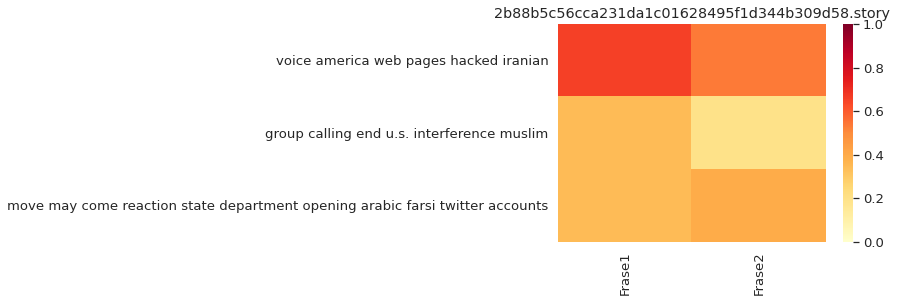

<Figure size 576x432 with 0 Axes>

f5abef893a7cad73aad2c9612abf5372f0dead90.story
	Frase 1: see full story ewcom
	Frase 2: every character show left draper ad agency either never heard revisited oneoff episode rarely never heard peggy contrast integral part show exploration 1960s thought completely losing emmynominated moss fans wee bit snit course moss appearance final moments season finale certainly suggested peggy story complete let get way wild speculation
0.22208893
0.54331803


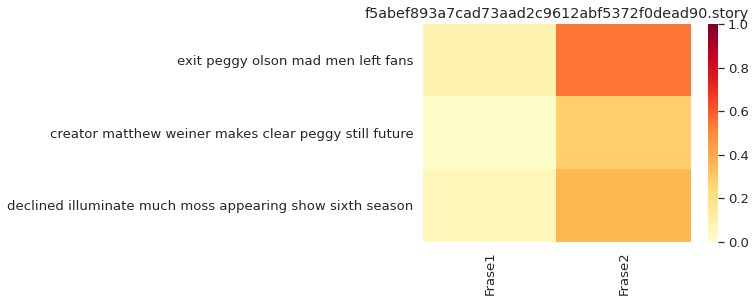

<Figure size 576x432 with 0 Axes>

dfbfd75bbe065b8ee61609ea415057299bc77b27.story
	Frase 1: historian sean wilentz wrote book age reagan carter appeared abdicating role leader blaming people afflictions
	Frase 2: president ronald reagan bomb
0.39202523
0.8310536


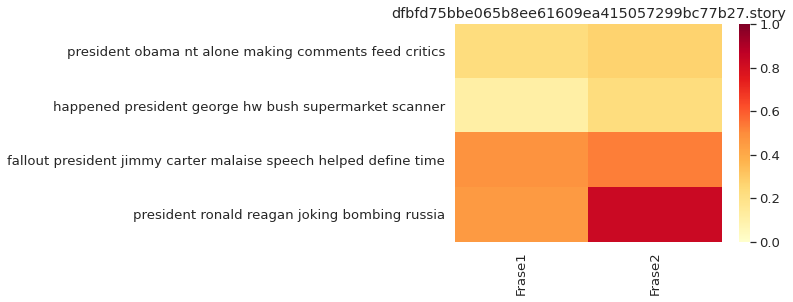

<Figure size 576x432 with 0 Axes>

ee3081fbc7cb90233a07a0f92b1eea1c65d42919.story
	Frase 1: iranian officials said sunday middle eastern nation create court focusing media crimes according staterun media reports move fueled fears tehran intensifying crackdown journalists
	Frase 2: challenge narrative government memarian said noting reports get funneled journalists like posted online anonymously role even nt go public role
0.43352395
0.7793497


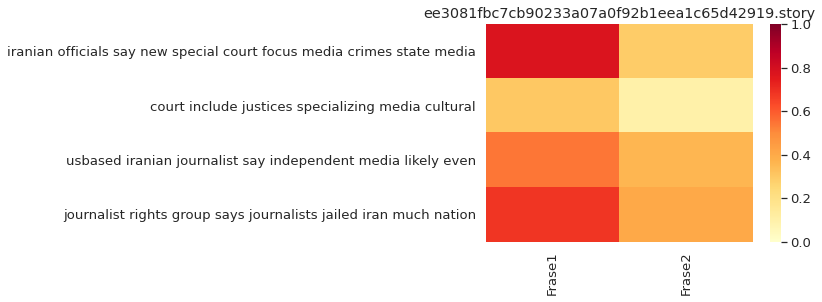

<Figure size 576x432 with 0 Axes>

5e66d2f19af3f88e1511e087b5c479c8e92229ad.story
	Frase 1: lionel messi broke spanish league alltime scoring record hitting hat trick barcelona 51 victory sevilla
	Frase 2: typical
0.2663772
0.7038183


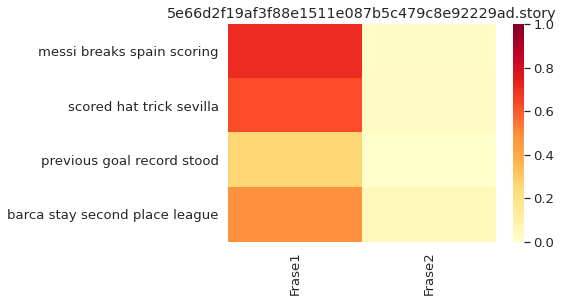

<Figure size 576x432 with 0 Axes>

1303b743cd57f6da6ddc91744439916a31129065.story
	Frase 1: people suffering thyroid dysfunction problems affect women men problem enough hormones made called hypothyroidism symptoms somewhat elusive probably doctors smith use handy tool help patients identify problem actually acronym use hypothyroidism said called sluggish sometimes feel sluggish might serve red flag might think oh might thyroid
	Frase 2: goiter enlarged thyroid
0.47157514
0.7017699


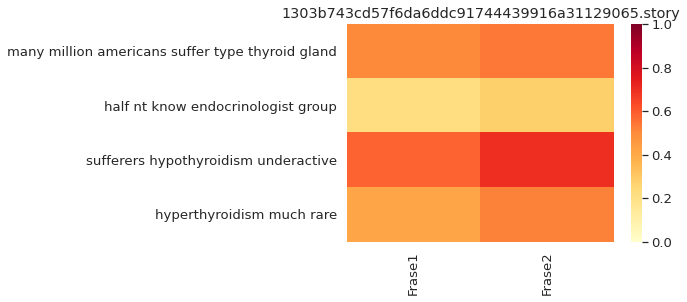

<Figure size 576x432 with 0 Axes>

256c290fa8cc7da3b80647059463852234b9492c.story
	Frase 1: wheeler went inside singing
	Frase 2: margaret flowers organizer popular resistance told decided change tone little bit gave wheeler wife bottle wine politely urged chairman internet hero adopting president proposals
0.18160552
0.27801406


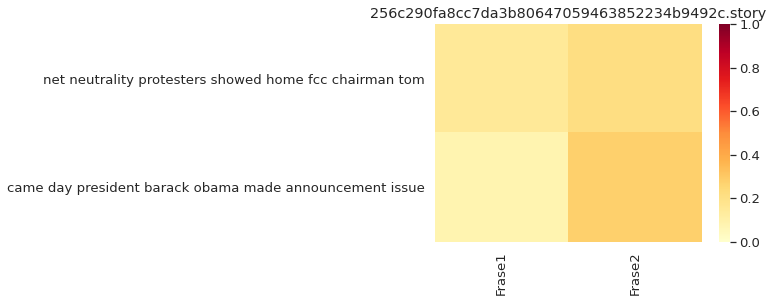

<Figure size 576x432 with 0 Axes>

23e4f0dd1830eee3aebc974dd00abc00992f4cba.story
	Frase 1: 900 1000 pm masterchef season finale
	Frase 2: thursday sept
0.24852403
0.33835682


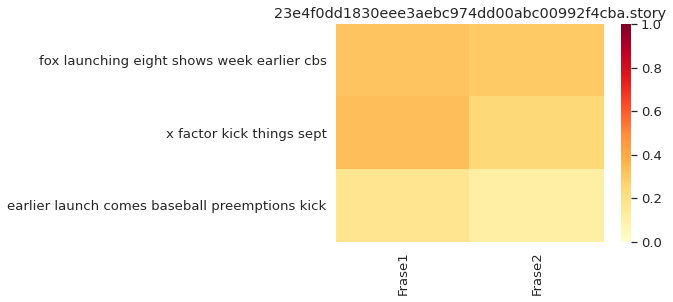

<Figure size 576x432 with 0 Axes>

a3d05902fabd11627502087046ffe5f0c584b8d8.story
	Frase 1: discovery channel airs pitchmen cohosted mays issued statement saying incredible sadness report billy mays died sleep last night everyone knows aware largerthanlife personality generosity warmth billy pioneer field helped many people fulfill dreams greatly missed loyal compassionate friend
	Frase 2: autopsy conducted monday morning revealed mays suffered hypertensive heart disease adams said
0.3251431
0.49577385


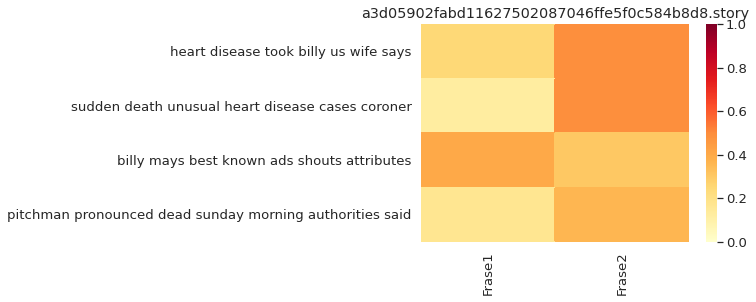

<Figure size 576x432 with 0 Axes>

e80d63e96326a3e4789a3da460a3683a5118fdea.story
	Frase 1: barbour told police wife tried kill others plans nt work
	Frase 2: 
0.18881646
0.5105136


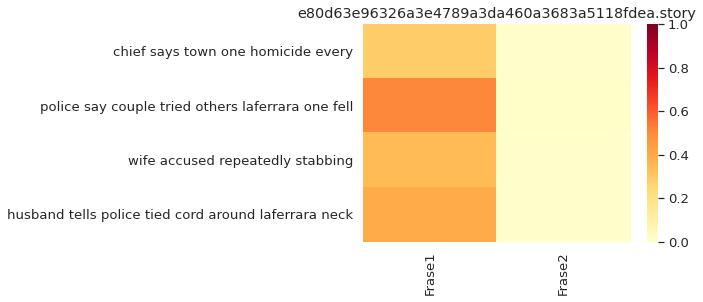

<Figure size 576x432 with 0 Axes>

6da4e34b8dbd3f99eda0b32a56a2514f39765098.story
	Frase 1: overdose blood thinner may contributed death nebraska toddler omaha hospital treated said thursday
	Frase 2: appears overdose blood thinner heparin may contributed said statement called death deeply troubling emotional incident hospital personnel want extend deepest apologies duque family tragic loss added
0.25362587
0.58291674


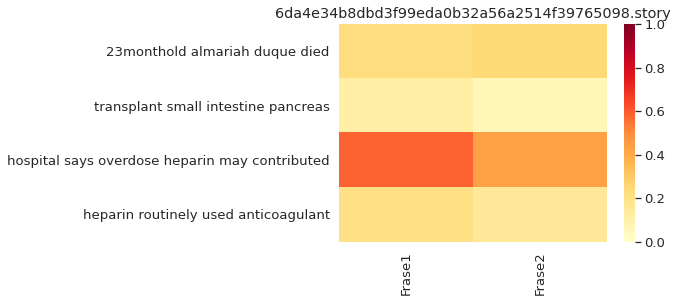

<Figure size 576x432 with 0 Axes>

1a4cf9e66cf130d5fcf19b37d245a1d4b029324b.story
	Frase 1: man pleaded guilty monday killing virginia tech graduate student restaurant january attacking knife decapitating according officials
	Frase 2: xin slaying first virginia tech campus since april seunghui cho killed students professors turning gun
0.34185126
0.7084452


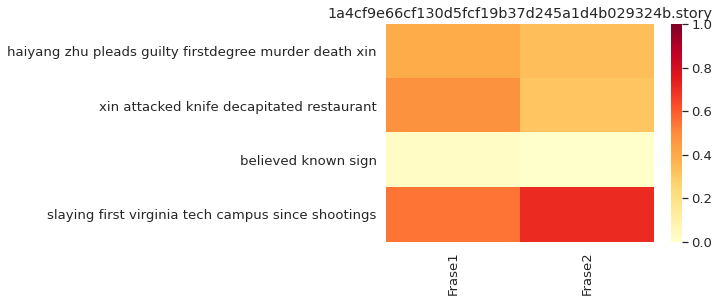

<Figure size 576x432 with 0 Axes>

620870a06edca3a41c5aac4e60e0fc96b944c9dd.story
	Frase 1: guambound united airlines flight forced land remote midway island pilots detected electrical odor experienced mechanical problem carrier said monday
	Frase 2: evacuation slide deploys midair united
0.30863327
0.44882694


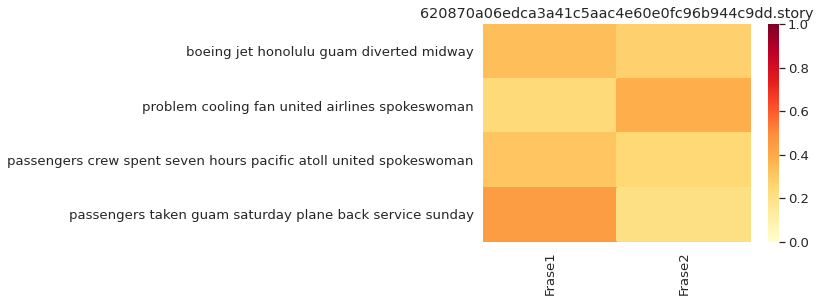

<Figure size 576x432 with 0 Axes>

80d05477ea3010417772b1b20bec17f9f55306f1.story
	Frase 1: ncaa rules say athletes may provided three meals day food stipend new rule would apply scholarship nonscholarship athletes
	Frase 2: decision legislative council would need approved division board directors meeting april
0.23752922
0.63704836


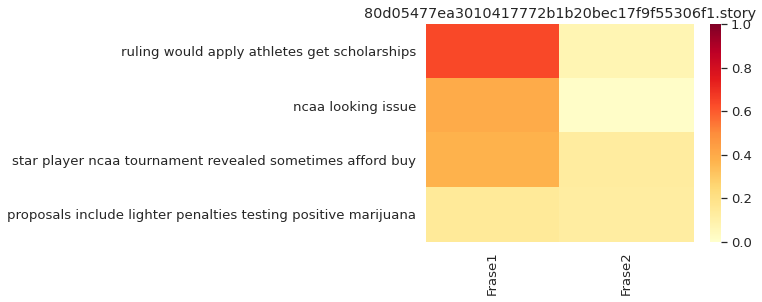

<Figure size 576x432 with 0 Axes>

d65e32e79d68a203ce672032446fc2cc5fc6bc89.story
	Frase 1: williams joins martina navratilova steffi graf chris evert fourth player ever win wta event six times
	Frase 2: look forward next matches going really fun fans us everyone
0.39866778
0.69921094


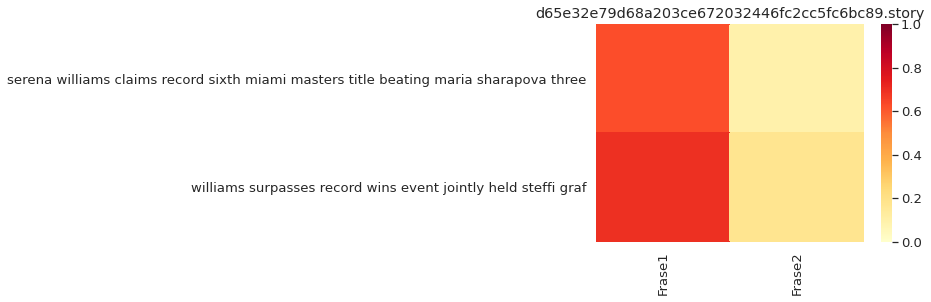

<Figure size 576x432 with 0 Axes>

323c822ef31775a479360563a461074dd9588f4a.story
	Frase 1: even though hillary clinton around nearly entire lifetime economist may speak many asks hillary stand paradox presents far bestknown presidential candidate across parties moment almost unchallenged within yet even though diane feinstein assert confidently hillary nt need white house wants question unanswered liberals believe government something lack definition surely disconcerting clinton
	Frase 2: clinton credentials fighter inequality mixed true wall street times notes previously called universal prekindergarten equal pay women increases minimum wage paid family leave higher taxes wealthy expanded earned income tax credit workingpoor families counts among friends precisely corporate people blamed occupy crowd country inequality clinton wisely trying distance clinton foundation fundraising efforts among foreign interests hardly stuff populist liberalism
0.44741216
0.5066891


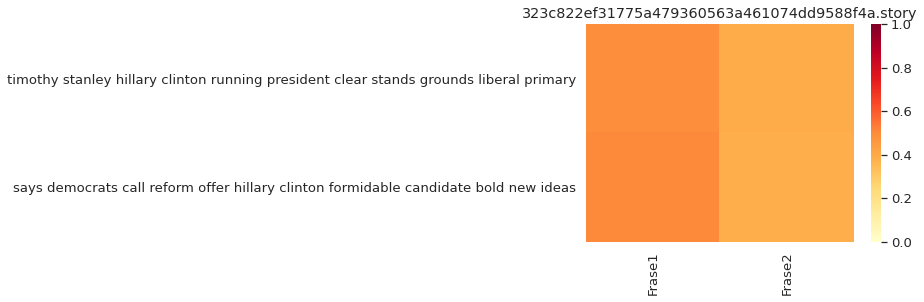

<Figure size 576x432 with 0 Axes>

3b1c6f1dcd6095fce94288046b8c98c2eb888781.story
	Frase 1: 78000 people fled south kordofan blue nile states since august last year armed rebellion took root united nations reported sudanese government thought responded rebellion conducting sustained air raids use russianmade antonov bombers raised concerns civilian casualties
	Frase 2: miracle one injured statement added
0.17805049
0.45899063


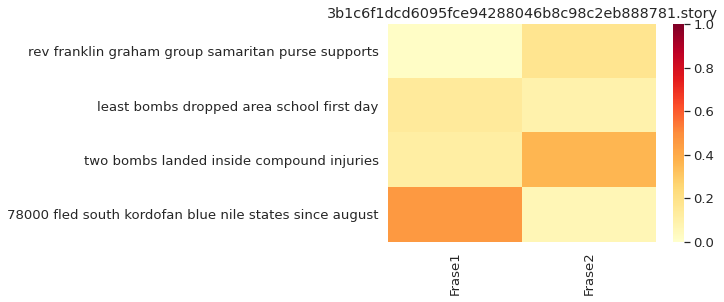

<Figure size 576x432 with 0 Axes>

4f3467789137df356b595be0758aff3aa18b62d2.story
	Frase 1: common sense always guide travel europe winter months stay deluxe accommodations would cost substantially spring summer seasons said werbin
	Frase 2: want take advantage cheapest time afloat reading cabin aboard cruise ship october prethanksgiving november time sail caribbean lastminute deal ohsoeasy wallet fringe hurricane season officially june 1st november 30th remember cruise ships alter routes storm hits whereas resort move path danger
0.14429298
0.26011777


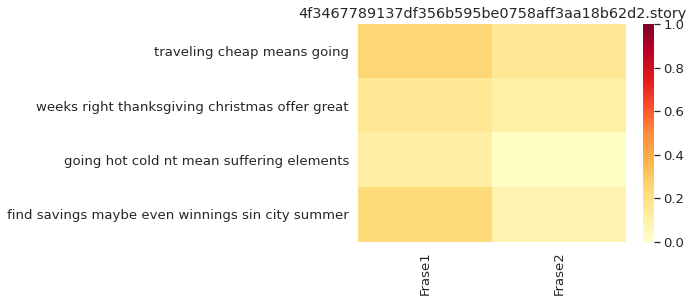

<Figure size 576x432 with 0 Axes>

1a6111ebc1e719bb2ca643ead7fbfdd16beb7257.story
	Frase 1: really use break fault klopp told reporters something started well ended badly
	Frase 2: bayer leverkusen lost second straight league game 10 werder bremen borussia dortmund bayern victim champions league final fell 21 home promoted hertha berlin
0.3457499
0.58978564


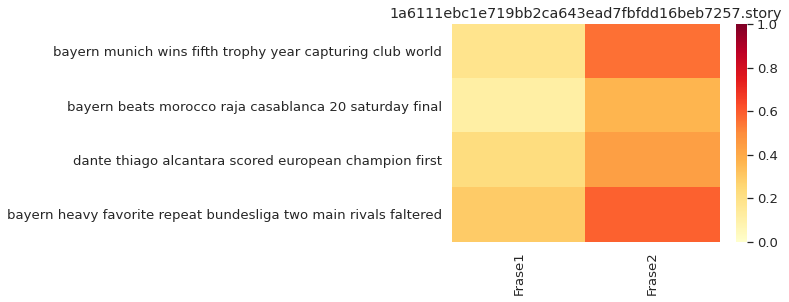

<Figure size 576x432 with 0 Axes>

cf7f2eca94b05f18a81750adf4f91ec7a72e17e8.story
	Frase 1: admissionsplash equation definitely nt take essays account pretty accurate tests use publicly available admissions profiles
	Frase 2: admission splash currently runs customized equations 1500 schools developed using admission data release
0.32815582
0.5741848


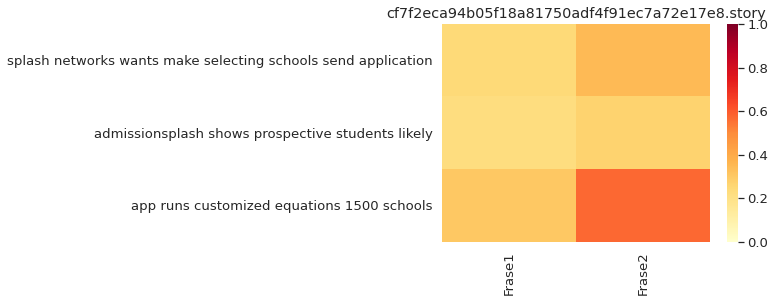

<Figure size 576x432 with 0 Axes>

13519607ff1cdc070b02ec214dae3122cb106ee3.story
	Frase 1: australian motogp star casey stoner leave ducati end season join japanese manufacturer honda
	Frase 2: clearly one top riders motogp bring valuable speed experience team
0.48469913
0.85767806


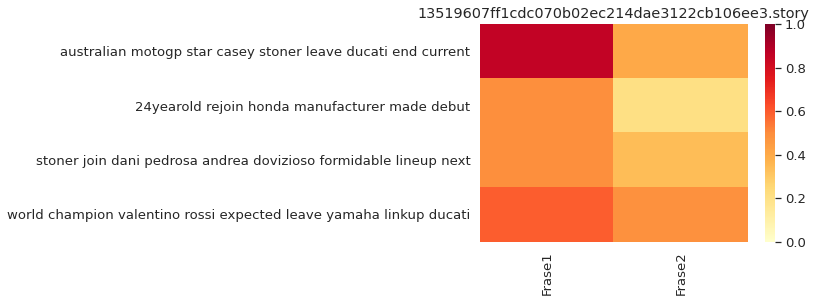

<Figure size 576x432 with 0 Axes>

average corr_value for all sumarized docs:
0.31479106843471527
highest corr_values for each doc: 
[0.6573256, 0.54331803, 0.8310536, 0.7793497, 0.7038183, 0.7017699, 0.27801406, 0.33835682, 0.49577385, 0.5105136, 0.58291674, 0.7084452, 0.44882694, 0.63704836, 0.69921094, 0.5066891, 0.45899063, 0.26011777, 0.58978564, 0.5741848, 0.85767806]
average high corr_value: 
0.5791994106201899
median corr_values: 
[0.37155735, 0.18378146, 0.36423883, 0.38191545, 0.15478119, 0.51327044, 0.18507472, 0.2723591, 0.33307233, 0.15069698, 0.21647853, 0.3658227, 0.29544345, 0.13677676, 0.39994246, 0.44859624, 0.12952784, 0.14014912, 0.32900342, 0.28963512, 0.4896878]


In [ ]:
average_corr_list = []
highest_corr_list = []
median_corr_list = []

# Roda a tradução e plota o heatmap da similaridade semântica
for doc in doc_melhores_sents_sents.keys():
    if random() <= 0.97:
        continue
    msgs1 = doc_melhores_sents_sents[doc]
    msgs2 = []
    for sent in doc_sents_highlight[doc]:
        msgs2.append(" ".join(sent))
    f1 = model(msgs1)
    f2 = model(msgs2)
    print(doc)
    for i, sent in enumerate(msgs1):
        print("\tFrase {}: {}".format(i+1, sent))
    corr1 = np.inner(f2,f1)
    avg_corr1 = corr1.mean()
    average_corr_list.append(avg_corr1)
    highest_corr_list.append(np.max(corr1))
    median_corr_list.append(np.median(corr1))
    print(avg_corr1)
    print(np.max(corr1))
    plot_similarity(["Frase1", "Frase2"], msgs2, f2, f1, 90, doc)


average_corr_total = sum(average_corr_list)/len(average_corr_list)
average_corr_high = sum(highest_corr_list)/len(highest_corr_list)
print("average corr_value for all sumarized docs:") 
print(average_corr_total)
print("highest corr_values for each doc: ")
print(highest_corr_list)
print("average high corr_value: ")
print(average_corr_high)
print("median corr_values: ")
print(median_corr_list)

Os resultados mostram que, entre a pequena amostra de validação, a média de similaridade foi de proximadamente 0,3104. Porém, considerando apenas a maior similaridade obtida em cada documento, a média foi de aproximadamente 0,5436 , o que é consideravelmente satisfatório para uma sumarização extrativa.

Há poucos casos em que ambas as frases obtidas apresentam similaridades menores que 0,3. Por outro lado, há poucos casos em que pelo menos uma das frases obtidas apresentam uma similaridade maior que 0,6.

### 3.2 Tradução

Não foi possível realizar a tradução com o modelo XLM devido a uma [incompatibilidade](https://github.com/facebookresearch/XLM/issues/208) do modelo disponibilizado e o método de execução disponibilizado no [repositório oficial](https://github.com/facebookresearch/XLM). 

Portanto, provisoriamente, implementou-se o modelo T5, da biblioteca transformers. Para mostrar os resultados, foi selecionada uma pequena amostra de documentos sumarizados. A tradução foi feita do inglês para o alemão, especificado na configuração do modelo. 

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

task_specific_params = model.config.task_specific_params
model.config.update(task_specific_params.get("translation_en_to_de", {}))

In [ ]:
try:
    with open("doc_trans_sents.pickle", "rb") as fp:
        doc_trans_sents = pickle.load(fp)
    print("Arquivo 'doc_trans_sents.pickle' carregado")
except FileNotFoundError as e:
    doc_sents_size = len(doc_sents)
    count = 0
    count2 = 0
    doc_trans_sents = defaultdict(list)
    for doc in list(doc_melhores_sents_sents.keys()):
        if random() <= 0.98:
            print("\r{}/{} - ".format(count, doc_sents_size), end="")
            count += 1
            continue
        print("\r{}/{} - {}".format(count, doc_sents_size, doc), end="")
        count += 1
        count2 += 1
        for sent in doc_melhores_sents_sents[doc]:
            encode_dict = tokenizer.encode_plus(model.config.prefix + " " + sent)    # Batch size 1
            input_ids = torch.tensor([encode_dict["input_ids"]])
            translations = model.generate(input_ids=input_ids)
            doc_trans_sents[doc].append(tokenizer.decode(translations[0]))
    print("\r{}/{} - {}".format(count, doc_sents_size, doc))
    print("sumários traduzidos: {} / {}".format(count2, doc_sents_size))
    with open("doc_trans_sents.pickle", "wb") as fp:
        pickle.dump(doc_trans_sents, fp)

748/749 - b3858ea6ae71f109a7eac9493a1057f0c4f31996.story
sumários traduzidos: 14 / 749


In [ ]:
for doc in list(doc_trans_sents.keys()):
    print(doc)
    for i in range(len(doc_trans_sents[doc])):
        print("\t{}o - {}".format(i, doc_melhores_sents_sents[doc][i]))
        print("\t{}t - {}".format(i, doc_trans_sents[doc][i]))

d11cb25a2422515e10b0d3e28dca49e452722248.story
	0o - ashley gallagher alden mahler levine contributed
	0t - ashley gallagher alden mahler levine hat einen Beitrag geleistet.
	1o - march government reported abdulhadi alkhawaja low blood pressure taken bahrain defense force hospital treated returned jau prison following day
	1t - März Regierung berichtete abdulhadi alkhawaja niedrigen Blutdruck genommen bahrain Verteidigungskräfte Krankenhaus behandelt zurück jau Gefängnis nach Tag.
17811a8d831d26f5a07a7de8cb19aa15d9439491.story
	0o - least two protesters killed oman tv editor asma rshid told
	0t - Mindestens zwei Demonstranten töteten oman TV-Redakteur Asma rshid erzählte.
	1o - caroline faraj victoria brown contributed report
	1t - caroline faraj victoria brown hat zum Bericht beigetragen.
12cbe2c9597febaf14e4db1e3065d7500082883e.story
	0o - tough night said morgan county executive tim conley fortunate report four dead could lost whole lot lives thing
	0t - tough night said morgan coun

Os resultados da tradução utilizando o modelo `T5` mostram que, quando ele não é capaz de traduzir ao menos uma parte da sentença esse modelo deixa de realizar a tradução da sentença inteira. Ou seja, há algumas sentenças traduzidas e outras não. Apesar da taxa de tradução não ser tão elevada, as sentenças que foram traduzidas se mostram bem consistentes no quesito de manter o sentido da frase.

Uma das possíveis explicações do porquê o modelo não consegue traduzir algumas sentenças é que estas foram processadas. Portanto, não seguem as regras de sintaxe como o modelo esperava.

# 4. Conclusão


Pode-se dizer que, em geral, os resultados experimentais deste projeto atingiram um grau de satisfação adequado. Como pretendido, melhorias significativas foram cumpridas no sumarizador do projeto anterior e, foi possível implementar um tradutor, mesmo que este não tenha utilizado o modelo proposto originalmente.

O trabalho também buscou deixar de forma clara, quais foram os métodos utilizados para que se possa trabalhar em melhorias. Apesar de haver muitos pontos que devem e podem ser melhorados, tanto no sumarizador quanto no tradutor, é válido notar que, este trabalho poderá sem dúvida servir como um ponto de partida para outros estudos e projetos no futuro. Por meio desta forma de documentação foi possível trazer o conteúdo estudado de forma sintetizada. Contando também com exemplos práticos e replicáveis. 

A satisfação na conclusão deste projeto não está somente nos resultados quantitativos — performance da implementação — mas também na sua documentação. Pois, abre a possibilidade de contribuir com os estudos futuros envolvendo diferentes abordagens.